# CSE 291 Assignment 2 BiLSTM CRF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CSE291B00_NLP/Project2/Models'

/content/drive/MyDrive/CSE291B00_NLP/Project2/Models


## Download Data/Eval Script




In [ ]:
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/dev.data.quad

--2021-05-28 00:49:13--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py.1’

conlleval.py.1      100%[===================>]   7.33K  --.-KB/s    in 0.001s  

2021-05-28 00:49:13 (5.16 MB/s) - ‘conlleval.py.1’ saved [7502/7502]

--2021-05-28 00:49:13--  https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745734 (728K) [text/plai

In [ ]:
import conlleval
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(291)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Data Preparation

In [ ]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    dataset = [
      [
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = Vocab(train_word_counter, specials=(UNK, PAD), min_freq=2)
#label_vocab = Vocab(train_label_counter, specials=(), min_freq=1) #for BiLSTM without CRF
label_vocab = Vocab(train_label_counter, specials=(START_TAG, STOP_TAG), min_freq=1)  # for BiLSTM with CRF
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')
valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data[1][1]]))

Train word vocab: 3947 symbols.
Train label vocab: 10 symbols: ['<start>', '<stop>', 'O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
Train data: 3420 sentences.
Valid data: 800
Pusan 0000 0000 0000 0000 0000 0000
I-ORG O O O O O O
Earlier this month , <unk> denied a Kabul government statement that the two sides had agreed to a ceasefire in the north .
O O O O I-PER O O I-LOC O O O O O O O O O O O O O O O


In [ ]:
# helper function
def argmax(value):
    _, idx = torch.max(value, 1)
    return idx.item()


## BiLSTMTagger with CRF

In [ ]:
# Implementing a BiLSTM CRF Tagger 
# which uses viterbi decoding algorithm

class BiLSTM_CRF_Tagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTM_CRF_Tagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True).to(device)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.dropout = nn.Dropout(p=dropout)

        # defining transition probabilities
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size)).to(device)
        # defining constraints for start and stop tags explicitly
        self.transitions.data[label_vocab.stoi[START_TAG], :] = -10000.0
        self.transitions.data[:, label_vocab.stoi[STOP_TAG]] = -10000.0

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence)).view(len(sentence), 1, -1)
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out.view(len(sentence), self.hidden_dim)
        bilstm_feats = self.tag_projection_layer(bilstm_out)
        # print('Shape of Features:', bilstm_feats)
        return bilstm_feats

    def forward_algorithm(self, features):

        init_alphas = torch.full((1, self.tagset_size), fill_value = -10000.0).to(device)
        init_alphas[0][label_vocab.stoi[START_TAG]] = 0.0
        forward_var = init_alphas
  
        for feature in features:

            emit_score = feature.view(-1, 1)
            tag_var = forward_var + self.transitions + emit_score
            forward_var = torch.logsumexp(tag_var, dim = 1).view(1, -1)
        
        terminal_var = (forward_var + self.transitions[label_vocab.stoi[STOP_TAG]]).view(1, -1)
        alpha = torch.logsumexp(terminal_var, dim = 1)
        #print('Alpha for vec:', alpha)
        return alpha
  
    def score_sentence(self, features, tags):

        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([label_vocab.stoi[START_TAG]], dtype=torch.long).to(device), tags])
        
        for i, feature in enumerate(features):
            score = score + self.transitions[tags[i + 1], tags[i]] + feature[tags[i + 1]]
            
        score = score + self.transitions[label_vocab.stoi[STOP_TAG], tags[-1]]
        # print('final score', score)
        return score

    def viterbi_decoding(self, features):
                
        backpointers = []
        # analogous to forward
        init_vvars = torch.full((1, self.tagset_size), -10000.0).to(device)
        init_vvars[0][label_vocab.stoi[START_TAG]] = 0.0
        forward_var = init_vvars

        for feat in features:
            next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
            _, bptrs_t = torch.max(next_tag_var, dim=1)
            bptrs_t = bptrs_t.squeeze().data.cpu().numpy()
            next_tag_var = next_tag_var.data.cpu().numpy()
            viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t]
            viterbivars_t = torch.FloatTensor(viterbivars_t).to(device)
            forward_var = viterbivars_t + feat
            backpointers.append(bptrs_t)

        terminal_var = forward_var + self.transitions[label_vocab.stoi[STOP_TAG]]
        terminal_var.data[label_vocab.stoi[STOP_TAG]] = -10000.0
        terminal_var.data[label_vocab.stoi[START_TAG]] = -10000.0
        
        best_tag_id = argmax(terminal_var.unsqueeze(0))
        path_score = terminal_var[best_tag_id]
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        
        start = best_path.pop()
        assert start == label_vocab.stoi[START_TAG]
        best_path.reverse()
        #print('VECTORISED:',path_score, best_path)
        return path_score, best_path
        
    def forward(self, sentence):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        best_score, tag_sequence = self.viterbi_decoding(bilstm_feats)
        return best_score, tag_sequence
    
    def neg_log_likelihood(self, sentence, tags):
        feats = self.compute_lstm_emission_features(sentence)
        forward_score = self.forward_algorithm(feats)
        # print(forward_score)
        gold_score = self.score_sentence(feats, tags)
        # print(gold_score)
        # print(forward_score, gold_score)
        return forward_score - gold_score


## Train / Eval loop for BiLSTM CRF 

In [ ]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    losses_per_epoch = []
    epoch_precision = []
    epoch_recall = []
    epoch_f1 = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags) in enumerate(train_data):
            # print(sent, tags)
            model.zero_grad()
            sent, tags = sent.to(device), tags.to(device)
            # print(tags, tags.shape)
            loss = model.neg_log_likelihood(sent, tags)
            # print('Loss:',loss)
            # print(loss.shape)
            loss.backward()
            optimizer.step()

            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                print(f'Avg loss over last {log_interval} updates: {np.mean(losses_per_epoch[-1][-log_interval:])}')

        sent, true_tags, pred_tags, avg_precision, avg_recall, avg_f1, avg_eval_loss = evaluate(model, valid_data, word_vocab, label_vocab)
        epoch_precision.append(avg_precision)
        epoch_recall.append(avg_recall)
        epoch_f1.append(avg_f1)
        epoch_eval_losses.append(avg_eval_loss)
    return losses_per_epoch, epoch_eval_losses, epoch_precision, epoch_recall, epoch_f1 



def evaluate(model, dataset, word_vocab, label_vocab):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            losses.append(model.neg_log_likelihood(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()])
            pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq])
            sents.append([word_vocab.itos[i] for i in sent])

    evaluation_metrics = conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    avg_precision = evaluation_metrics[0]
    avg_recall = evaluation_metrics[1]
    avg_f1 = evaluation_metrics[2]
    avg_eval_loss = np.mean(losses)
    #print ('dataType:', type(evaluation_metrics))
    print('Avg evaluation loss:', np.mean(losses))
    # print(evaluation_metrics)
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags, avg_precision, avg_recall, avg_f1, avg_eval_loss


## Training for BiLSTM CRF

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model_crf.apply(init_weights)

BiLSTM_CRF_Tagger(
  (word_embeds): Embedding(3947, 128)
  (bilstm): LSTM(128, 128, bidirectional=True)
  (tag_projection_layer): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model_crf.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_crf):,} trainable parameters')

The model has 772,078 trainable parameters


### Epochs = 30

In [ ]:
model_crfn = BiLSTM_CRF_Tagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_crfn.parameters(), lr=1e-3)
train_loss_30, val_loss_30, precision_val_30, recall_val_30, f1_val_30 = train(model_crfn, train_data, valid_data, word_vocab, label_vocab, epochs= 30, log_interval=500)
torch.save(model_crfn.state_dict(), 'model_30_cpu.pt')

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.680868079662323
Avg loss over last 500 updates: 8.193839848041534
Avg loss over last 500 updates: 6.287678160905838
Avg loss over last 500 updates: 5.60708591890335
Avg loss over last 500 updates: 4.768070904493332
Avg loss over last 500 updates: 4.684621188402176
processed 11170 tokens with 1231 phrases; found: 748 phrases; correct: 478.
accuracy:  46.75%; (non-O)
accuracy:  89.06%; precision:  63.90%; recall:  38.83%; FB1:  48.31
              LOC: precision:  80.43%; recall:  40.77%; FB1:  54.11  184
             MISC: precision:  55.56%; recall:  15.62%; FB1:  24.39  54
              ORG: precision:  58.12%; recall:  36.16%; FB1:  44.58  191
              PER: precision:  59.25%; recall:  51.22%; FB1:  54.94  319
Avg evaluation loss: 4.325317813158035

5 random evaluation samples:
SENT: Russian officials , <unk> to cut capital flight , will <unk> tight measures to cut barter deals in foreign trade to a <unk> , a customs official sai

In [ ]:
# load model
model.load_state_dict(torch.load('model_30_cpu.pt', map_location=torch.device('cpu')))

## Data Preparation Baseline

In [ ]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    dataset = [
      [
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = Vocab(train_word_counter, specials=(UNK, PAD), min_freq=2)
label_vocab = Vocab(train_label_counter, specials=(), min_freq=1) #for BiLSTM without CRF
#label_vocab = Vocab(train_label_counter, specials=(START_TAG, STOP_TAG), min_freq=1)  # for BiLSTM with CRF
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')
valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data[1][1]]))

Train word vocab: 3947 symbols.
Train label vocab: 8 symbols: ['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
Train data: 3420 sentences.
Valid data: 800
Pusan 0000 0000 0000 0000 0000 0000
I-ORG O O O O O O
Earlier this month , <unk> denied a Kabul government statement that the two sides had agreed to a ceasefire in the north .
O O O O I-PER O O I-LOC O O O O O O O O O O O O O O O


## BiLSTM Tagger Baseline

In [ ]:
# Starter code implementing a BiLSTM Tagger
# which makes locally normalized, independent
# tag classifications at each time step

class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0):
        super(BiLSTMTagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence))
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out
        bilstm_feats = self.tag_projection_layer(bilstm_out)
        return bilstm_feats

    
    def forward(self, sentence):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        return bilstm_feats.max(-1)[0].sum(), bilstm_feats.argmax(-1)

    def loss(self, sentence, tags):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        # transform predictions to (n_examples, n_classes) and ground truth to (n_examples)
        return torch.nn.functional.cross_entropy(
              bilstm_feats.view(-1, self.tagset_size), 
              tags.view(-1), 
              reduction='sum'
            )

## Train/Eval Loop for BiLSTM Baseline

In [ ]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    losses_per_epoch = []
    epoch_precision = []
    epoch_recall = []
    epoch_f1 = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags) in enumerate(train_data):
            model.zero_grad()
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            loss = model.loss(sent, tags)
            loss.backward()
            optimizer.step()

            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                print(f'Avg loss over last {log_interval} updates: {np.mean(losses_per_epoch[-1][-log_interval:])}')

        sent, true_tags, pred_tags, avg_precision, avg_recall, avg_f1, avg_eval_loss = evaluate(model, valid_data, word_vocab, label_vocab)
        epoch_precision.append(avg_precision)
        epoch_recall.append(avg_recall)
        epoch_f1.append(avg_f1)
        epoch_eval_losses.append(avg_eval_loss)
    return losses_per_epoch, epoch_eval_losses, epoch_precision, epoch_recall, epoch_f1 

def evaluate(model, dataset, word_vocab, label_vocab):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]])
            pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab.itos[i] for i in sent[0]])

    evaluation_metrics = conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    avg_precision = evaluation_metrics[0]
    avg_recall = evaluation_metrics[1]
    avg_f1 = evaluation_metrics[2]
    avg_eval_loss = np.mean(losses)
    print('Avg evaluation loss:', np.mean(losses))
    
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags, avg_precision, avg_recall, avg_f1, avg_eval_loss

## Training for BiLSTM Baseline

In [ ]:
model_b = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_b.parameters(), lr=1e-3)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model_b.apply(init_weights)

BiLSTMTagger(
  (word_embeds): Embedding(3947, 128)
  (bilstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (tag_projection_layer): Linear(in_features=256, out_features=8, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_b):,} trainable parameters')

### Epochs = 30

In [ ]:
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss_30bcpu, val_loss_30bcpu, precision_val_30bcpu, recall_val_30bcpu, f1_val_30bcpu = train(model, train_data, valid_data, word_vocab, label_vocab, epochs= 30, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.479876971304417
Avg loss over last 500 updates: 8.201994143217801
Avg loss over last 500 updates: 6.604658827404958
Avg loss over last 500 updates: 5.775679902212694
Avg loss over last 500 updates: 4.989824093624018
Avg loss over last 500 updates: 5.131092476454564
processed 11170 tokens with 1231 phrases; found: 775 phrases; correct: 465.
accuracy:  43.56%; (non-O)
accuracy:  89.39%; precision:  60.00%; recall:  37.77%; FB1:  46.36
              LOC: precision:  77.55%; recall:  41.87%; FB1:  54.38  196
             MISC: precision:  57.97%; recall:  20.83%; FB1:  30.65  69
              ORG: precision:  54.63%; recall:  36.48%; FB1:  43.75  205
              PER: precision:  52.79%; recall:  43.63%; FB1:  47.77  305
Avg evaluation loss: 4.666026122638214

5 random evaluation samples:
SENT: Pakistani bourse to use new <unk> index .
TRUE: I-MISC O O O O O O O
PRED: O O O O O O O O
SENT: 8. <unk> <unk> ( Kenya ) <unk>
TRUE: O I-PER I-PER

In [ ]:
torch.save(model.state_dict(), 'model_baseline_30_cpu.pt')

In [ ]:
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.load_state_dict(torch.load('model_baseline_30_cpu.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

## Plot for Models with Epochs= 30 and Dropout = 0.3

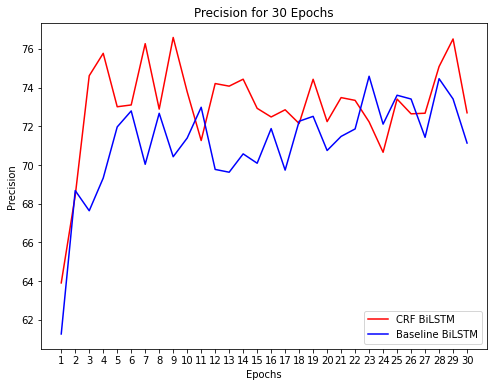

In [ ]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('Precision for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(x,precision_val_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,precision_val_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

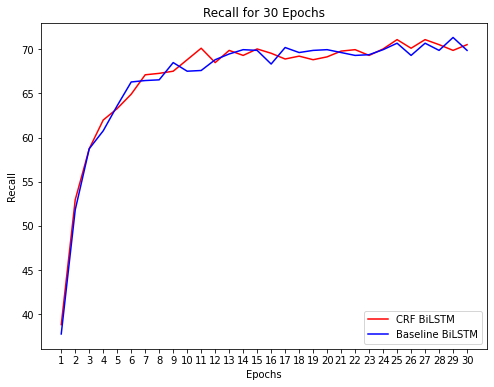

In [ ]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('Recall for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.plot(x,recall_val_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,recall_val_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

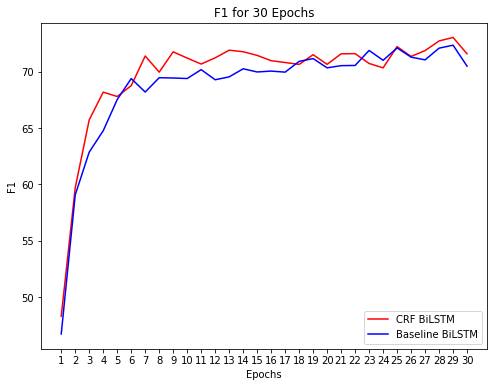

In [ ]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('F1 for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.plot(x,f1_val_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,f1_val_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

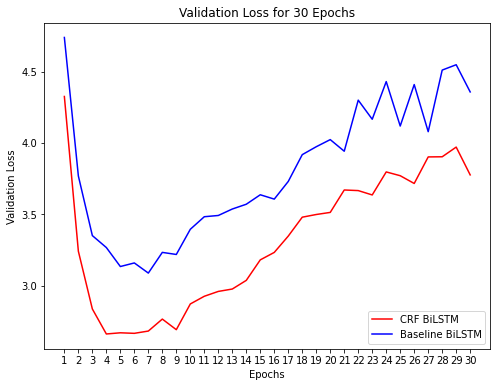

In [ ]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('Validation Loss for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.plot(x,val_loss_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,val_loss_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

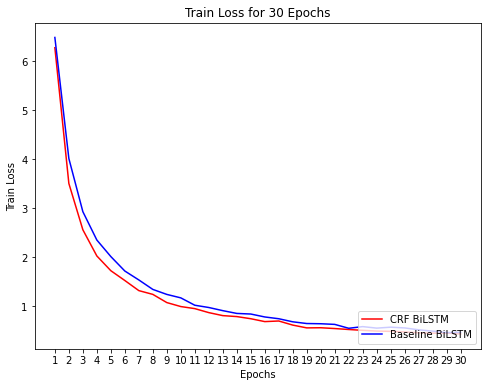

In [ ]:
avg_train_loss_30 = [sum(i)/len(i) for i in train_loss_30]
avg_train_loss_30b = [sum(i)/len(i) for i in train_loss_30b]

plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('Train Loss for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.plot(x,avg_train_loss_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,avg_train_loss_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

## Plot for Models with Epochs= 30 and No Dropout

In [ ]:
model_bn = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_bn.parameters(), lr=1e-3)
tl_30b, vl_30b, p_30b, r_30b, f1_30b = train(model_bn, train_data, valid_data, word_vocab, label_vocab, epochs= 30, log_interval=500)
torch.save(model_bn.state_dict(), 'model_30_baseline(526))_nodropout.pt')

--- EPOCH 0 ---
Avg loss over last 500 updates: 8.94719408288598
Avg loss over last 500 updates: 7.455759861215949
Avg loss over last 500 updates: 5.761054266269319
Avg loss over last 500 updates: 4.98977780761011
Avg loss over last 500 updates: 4.108768757198937
Avg loss over last 500 updates: 4.012933356399415
processed 11170 tokens with 1231 phrases; found: 958 phrases; correct: 598.
accuracy:  54.96%; (non-O)
accuracy:  90.98%; precision:  62.42%; recall:  48.58%; FB1:  54.64
              LOC: precision:  80.26%; recall:  51.52%; FB1:  62.75  233
             MISC: precision:  68.57%; recall:  37.50%; FB1:  48.48  105
              ORG: precision:  52.44%; recall:  42.02%; FB1:  46.65  246
              PER: precision:  56.15%; recall:  56.91%; FB1:  56.53  374
Avg evaluation loss: 4.084420607697211

5 random evaluation samples:
SENT: -- <unk> newsroom , 0000 0000 <unk> <unk>
TRUE: O I-LOC O O O O I-PER O
PRED: O I-ORG O O O O O O
SENT: Tom <unk> -- <unk> , 0000 , was <unk> unknow

In [ ]:
model_c = BiLSTM_CRF_Tagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_c.parameters(), lr=1e-3)
tl_30, vl_30, p_30, r30, f1_30 = train(model_c, train_data, valid_data, word_vocab, label_vocab, epochs= 30, log_interval=500)
torch.save(model_crfn.state_dict(), 'model_30_(526)_nodropout.pt')

--- EPOCH 0 ---
Avg loss over last 500 updates: 8.327773087501527
Avg loss over last 500 updates: 6.771486985206604
Avg loss over last 500 updates: 5.206407282352448
Avg loss over last 500 updates: 4.5468388686180115
Avg loss over last 500 updates: 3.7594984858036042
Avg loss over last 500 updates: 3.6425047318935393
processed 11170 tokens with 1231 phrases; found: 864 phrases; correct: 608.
accuracy:  55.73%; (non-O)
accuracy:  91.11%; precision:  70.37%; recall:  49.39%; FB1:  58.04
              LOC: precision:  80.23%; recall:  57.02%; FB1:  66.67  258
             MISC: precision:  72.04%; recall:  34.90%; FB1:  47.02  93
              ORG: precision:  59.91%; recall:  41.37%; FB1:  48.94  212
              PER: precision:  68.77%; recall:  56.10%; FB1:  61.79  301
Avg evaluation loss: 3.509747713804245

5 random evaluation samples:
SENT: India <unk> <unk> ' 0000 sales , output up .
TRUE: I-LOC I-ORG O O O O O O O O
PRED: I-LOC I-LOC O O O O O O O O
SENT: Indian officials blame <u

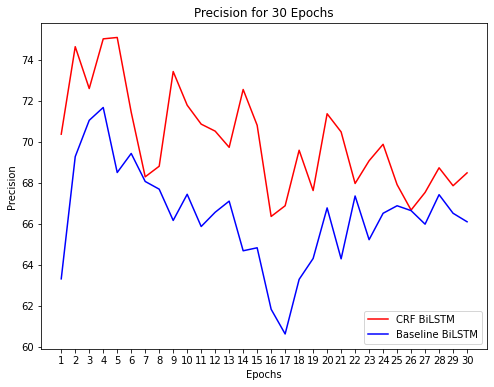

In [ ]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('Precision for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(x, p_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x, p_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

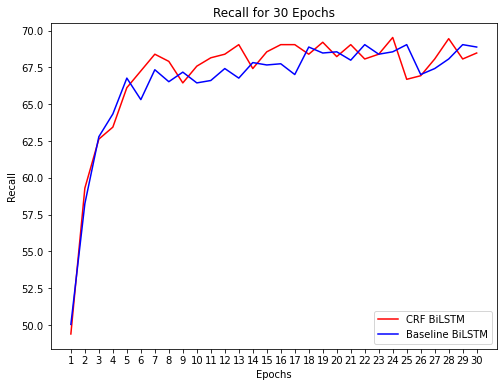

In [ ]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('Recall for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.plot(x, r30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x, r_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

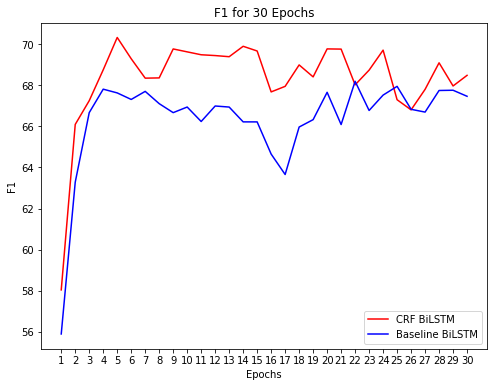

In [ ]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('F1 for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.plot(x, f1_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x, f1_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

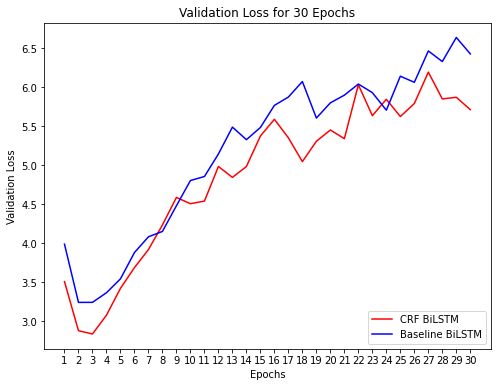

In [ ]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('Validation Loss for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.plot(x, vl_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x, vl_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

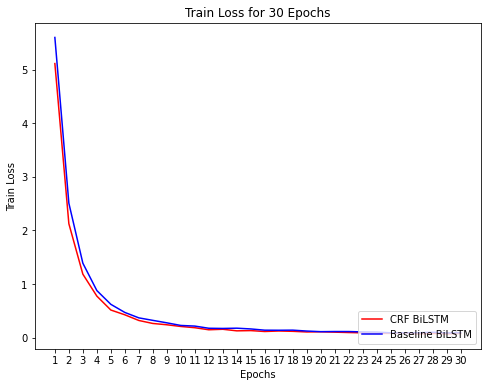

In [ ]:
avg_tl_30 = [np.mean(i) for i in tl_30]
avg_tl_30b = [np.mean(i) for i in tl_30b]

plt.figure(figsize = (8,6))
plt.xticks(x)
plt.title('Train Loss for 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.plot(x,avg_tl_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,avg_tl_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

## Analysis of Models

In [ ]:
valid_data_oov = []
valid_data_in = []
for value in valid_data:
    l = [word_vocab.itos[i.item()] for i in value[0]]
    if '<unk>' in l:
      valid_data_oov.append(value)
    else:
      valid_data_in.append(value)

In [ ]:
model_crfn = BiLSTM_CRF_Tagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_crfn.parameters(), lr=1e-3)

In [ ]:
model_crfn.load_state_dict(torch.load('model_30_cpu.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# For ENTIRE VALID DATA 
sents_1, true_tags_1, pred_tags_1 ,precision_1, recall_1 , f1_1, vl_1= evaluate(model_crfn, valid_data, word_vocab, label_vocab)

processed 11170 tokens with 1231 phrases; found: 1189 phrases; correct: 877.
accuracy:  75.83%; (non-O)
accuracy:  94.30%; precision:  73.76%; recall:  71.24%; FB1:  72.48
              LOC: precision:  84.36%; recall:  83.20%; FB1:  83.77  358
             MISC: precision:  77.24%; recall:  58.33%; FB1:  66.47  145
              ORG: precision:  63.95%; recall:  61.24%; FB1:  62.56  294
              PER: precision:  70.15%; recall:  74.53%; FB1:  72.27  392
Avg evaluation loss: 3.798002826273441

5 random evaluation samples:
SENT: <unk> <unk> 0000 <unk> <unk> 0000
TRUE: I-ORG I-ORG O I-ORG I-ORG O
PRED: I-ORG I-ORG O I-ORG I-ORG O
SENT: <unk> <unk> <unk> 5,000 Japan
TRUE: I-MISC O O O I-LOC
PRED: I-MISC I-MISC O O I-LOC
SENT: <unk> 1996-12-06
TRUE: I-LOC O
PRED: I-LOC O
SENT: There is nothing left for us but to be <unk> to <unk> for <unk> <unk> , " <unk> <unk> said .
TRUE: O O O O O O O O O O O O O O O O O I-ORG I-ORG O O
PRED: O O O O O O O O O O O O O O O O O I-PER I-PER O O
SENT: 

In [ ]:
# For OOV VALID DATA
sents_2, true_tags_2, pred_tags_2 ,precision_2, recall_2, f1_2, vl_2= evaluate(model_crfn, valid_data_oov, word_vocab, label_vocab)

processed 10403 tokens with 1127 phrases; found: 1088 phrases; correct: 778.
accuracy:  74.87%; (non-O)
accuracy:  93.96%; precision:  71.51%; recall:  69.03%; FB1:  70.25
              LOC: precision:  84.09%; recall:  81.45%; FB1:  82.75  308
             MISC: precision:  72.39%; recall:  54.49%; FB1:  62.18  134
              ORG: precision:  59.92%; recall:  57.25%; FB1:  58.56  257
              PER: precision:  68.89%; recall:  74.03%; FB1:  71.37  389
Avg evaluation loss: 4.783063806336502

5 random evaluation samples:
SENT: <unk> is <unk> by the level of competition in the <unk> .
TRUE: I-PER O O O O O O O O O O O
PRED: O O O O O O O O O O O O
SENT: USDA gross <unk> <unk> and <unk> value .
TRUE: I-ORG O O O O O O O
PRED: I-ORG O O O O O O O
SENT: " It can be stated beyond <unk> <unk> that this <unk> is not that of the late <unk> , " the <unk> said in a statement .
TRUE: O O O O O O O O O O O O O O O O O O O O O O O O O O O
PRED: O O O O O O O O O O O O O O O O O O O O O I-ORG 

In [ ]:
# For IV VALID DATA
sents_3, true_tags_3, pred_tags_3 ,precision_3, recall_3, f1_3, vl_3= evaluate(model_crfn, valid_data_in, word_vocab, label_vocab)

processed 767 tokens with 101 phrases; found: 102 phrases; correct: 95.
accuracy:  95.04%; (non-O)
accuracy:  98.96%; precision:  93.14%; recall:  94.06%; FB1:  93.60
              LOC: precision:  95.56%; recall:  95.56%; FB1:  95.56  45
             MISC: precision:  86.67%; recall: 100.00%; FB1:  92.86  15
              ORG: precision:  91.67%; recall:  91.67%; FB1:  91.67  36
              PER: precision: 100.00%; recall:  85.71%; FB1:  92.31  6
Avg evaluation loss: 0.2897438414302873

5 random evaluation samples:
SENT: for , against , points ) :
TRUE: O O O O O O O
PRED: O O O O O O O
SENT: -DOCSTART-
TRUE: O
PRED: O
SENT: -DOCSTART-
TRUE: O
PRED: O
SENT: BRUSSELS 1996-08-24
TRUE: I-LOC O
PRED: I-LOC O
SENT: Port Vale 0000 0000 0000 0000 0000 0000 0000
TRUE: I-ORG I-ORG O O O O O O O
PRED: I-ORG I-ORG O O O O O O O


In [ ]:
# For ENTIRE TRAIN DATA
sents_4, true_tags_4, pred_tags_4 ,precision_4, recall_4, f1_4, vl_4= evaluate(model_crfn, train_data, word_vocab, label_vocab)

processed 46565 tokens with 5279 phrases; found: 5259 phrases; correct: 5150.
accuracy:  98.73%; (non-O)
accuracy:  99.61%; precision:  97.93%; recall:  97.56%; FB1:  97.74
              LOC: precision:  98.72%; recall:  98.47%; FB1:  98.60  1568
             MISC: precision:  97.67%; recall:  96.67%; FB1:  97.16  772
              ORG: precision:  97.00%; recall:  96.87%; FB1:  96.94  1435
              PER: precision:  98.11%; recall:  97.72%; FB1:  97.92  1484
Avg evaluation loss: 0.16048483346637926

5 random evaluation samples:
SENT: <unk> said the cost of <unk> can be heavy once the company is <unk> into a contract .
TRUE: I-PER O O O O O O O O O O O O O O O O O
PRED: I-PER O O O O O O O O O O O O O O O O O
SENT: - Two investors who claim to be <unk> nearly one million Irish pounds by fund manager Tony Taylor believe they may have lost their money .
TRUE: O O O O O O O O O O O I-MISC O O O O I-PER I-PER O O O O O O O O
PRED: O O O O O O O O O O O I-MISC O O O O I-PER I-PER O O O 

In [ ]:
# LOAD MODEL WITHOUT DROPOUT
model_crf_nd = BiLSTM_CRF_Tagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_crf_nd.parameters(), lr=1e-3)
model_crf_nd.load_state_dict(torch.load('model_30_(526)_nodropout.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# For ENTIRE VALID DATA 
print("---Evaluation on Entire Validation Data---")
sents_1n, true_tags_1n, pred_tags_1n ,precision_1n , recall_1n, f1_1n, vl_1n= evaluate(model_crf_nd, valid_data, word_vocab, label_vocab)
# For OOV VALID DATA
print("---Evaluation on OOV Validation Data---")
sents_2n, true_tags_2n, pred_tags_2n ,precision_2n, recall_2n, f1_2n, vl_2n= evaluate(model_crf_nd, valid_data_oov, word_vocab, label_vocab)
# For IV VALID DATA
print("---Evaluation on IV Validation Data---")
sents_3n, true_tags_3n, pred_tags_3n ,precision_3n, recall_3n, f1_3n, vl_3n= evaluate(model_crf_nd, valid_data_in, word_vocab, label_vocab)
# For ENTIRE TRAIN DATA
print("---Evaluation on Entire Train Data---")
sents_4n, true_tags_4n, pred_tags_4n ,precision_4n, recall_4n, f1_4n, vl_4n= evaluate(model_crf_nd, train_data, word_vocab, label_vocab)

---Evaluation on Entire Validation Data---
processed 11170 tokens with 1231 phrases; found: 1196 phrases; correct: 864.
accuracy:  75.77%; (non-O)
accuracy:  94.17%; precision:  72.24%; recall:  70.19%; FB1:  71.20
              LOC: precision:  83.81%; recall:  81.27%; FB1:  82.52  352
             MISC: precision:  75.00%; recall:  57.81%; FB1:  65.29  148
              ORG: precision:  62.67%; recall:  59.61%; FB1:  61.10  292
              PER: precision:  68.07%; recall:  74.53%; FB1:  71.15  404
Avg evaluation loss: 3.834155965000391

5 random evaluation samples:
SENT: <unk> <unk> 0000 <unk> Munich 0000 ( <unk> <unk> , <unk> <unk> and
TRUE: I-ORG I-ORG O I-ORG I-ORG O O I-PER O O I-PER O O
PRED: I-ORG I-ORG O I-ORG I-ORG O O I-PER O O O O O
SENT: He spent a year under house arrest and was tried but <unk> last year on charges of ordering the murder of four <unk> in 0000 .
TRUE: O O O O O O O O O O O O O O O O O O O O O O O O O O
PRED: O O O O O O O O O O O O O O O O O O O O O O O 

In [ ]:
# LOAD BASELINE MODEL WITH DROPOUT
model_b = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_b.parameters(), lr=1e-3)
model_b.load_state_dict(torch.load('model_baseline_30_cpu.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# For ENTIRE VALID DATA 
print("---Evaluation on Entire Validation Data---")
sents_1b, true_tags_1b, pred_tags_1b ,precision_1b , recall_1b, f1_1b, vl_1b= evaluate(model_b, valid_data, word_vocab, label_vocab)
# For OOV VALID DATA
print("---Evaluation on OOV Validation Data---")
sents_2b, true_tags_2b, pred_tags_2b ,precision_2b, recall_2b, f1_2b, vl_2b= evaluate(model_b, valid_data_oov, word_vocab, label_vocab)
# For IV VALID DATA
print("---Evaluation on IV Validation Data---")
sents_3b, true_tags_3b, pred_tags_3b ,precision_3b, recall_3b, f1_3b, vl_3b= evaluate(model_b, valid_data_in, word_vocab, label_vocab)
# For ENTIRE TRAIN DATA
print("---Evaluation on Entire Train Data---")
sents_4b, true_tags_4b, pred_tags_4b ,precision_4b, recall_4b, f1_4b, vl_4b= evaluate(model_b, train_data, word_vocab, label_vocab)

---Evaluation on Entire Validation Data---
processed 11170 tokens with 1231 phrases; found: 1203 phrases; correct: 864.
accuracy:  75.88%; (non-O)
accuracy:  94.40%; precision:  71.82%; recall:  70.19%; FB1:  70.99
              LOC: precision:  86.49%; recall:  79.34%; FB1:  82.76  333
             MISC: precision:  74.65%; recall:  55.21%; FB1:  63.47  142
              ORG: precision:  64.69%; recall:  60.26%; FB1:  62.39  286
              PER: precision:  64.48%; recall:  77.24%; FB1:  70.28  442
Avg evaluation loss: 4.687124769301511

5 random evaluation samples:
SENT: -- Chicago newsdesk , <unk>
TRUE: O I-LOC O O O
PRED: O I-LOC O O I-PER
SENT: BUENOS AIRES 1996-08-26
TRUE: I-LOC I-LOC O
PRED: I-LOC I-LOC O
SENT: Extras ( <unk> <unk> <unk> <unk> ) 0000
TRUE: O O O O O O O O
PRED: O O O O O O O O
SENT: <unk> <unk> <unk> on reports of a plan to build property <unk> <unk> $ 0000 billion in Jakarta and <unk> .
TRUE: O I-ORG I-ORG O O O O O O O O O O O O O O I-LOC O I-LOC O
PRED: O O

In [ ]:
# LOAD BASELINE MODEL WITHOUT DROPOUT
model_bn = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_bn.parameters(), lr=1e-3)
model_bn.load_state_dict(torch.load('model_30_baseline(526))_nodropout.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# For ENTIRE VALID DATA 
print("---Evaluation on Entire Validation Data---")
sents_1bn, true_tags_1bn, pred_tags_1bn ,precision_1bn , recall_1bn, f1_1bn, vl_1bn= evaluate(model_bn, valid_data, word_vocab, label_vocab)
# For OOV VALID DATA
print("---Evaluation on OOV Validation Data---")
sents_2bn, true_tags_2bn, pred_tags_2bn ,precision_2bn, recall_2bn, f1_2bn, vl_2bn= evaluate(model_bn, valid_data_oov, word_vocab, label_vocab)
# For IV VALID DATA
print("---Evaluation on IV Validation Data---")
sents_3bn, true_tags_3bn, pred_tags_3bn ,precision_3bn, recall_3bn, f1_3bn, vl_3bn= evaluate(model_bn, valid_data_in, word_vocab, label_vocab)
# For ENTIRE TRAIN DATA
print("---Evaluation on Entire Train Data---")
sents_4bn, true_tags_4bn, pred_tags_4bn ,precision_4bn, recall_4bn, f1_4bn, vl_4bn= evaluate(model_bn, train_data, word_vocab, label_vocab)

---Evaluation on Entire Validation Data---
processed 11170 tokens with 1231 phrases; found: 1267 phrases; correct: 847.
accuracy:  73.40%; (non-O)
accuracy:  93.46%; precision:  66.85%; recall:  68.81%; FB1:  67.81
              LOC: precision:  86.02%; recall:  76.31%; FB1:  80.88  322
             MISC: precision:  68.15%; recall:  55.73%; FB1:  61.32  157
              ORG: precision:  56.79%; recall:  59.93%; FB1:  58.32  324
              PER: precision:  60.13%; recall:  75.61%; FB1:  66.99  464
Avg evaluation loss: 6.622364918089281

5 random evaluation samples:
SENT: <unk> 's <unk> still have majority .
TRUE: I-PER O I-MISC O O O O
PRED: I-ORG O O O O O O
SENT: Hapoel <unk> <unk> four Jewish players and two foreign <unk> -- a <unk> and a <unk> .
TRUE: I-ORG I-ORG O O I-MISC O O O O O O O I-MISC O O I-MISC O
PRED: I-ORG I-ORG O O I-MISC O O O O O O O O O O O O
SENT: -- Bangkok newsroom <unk>
TRUE: O I-LOC O O
PRED: O I-MISC O O
SENT: Pakistan , who <unk> next week , are the thir